<h1>Mimicking The Peregrine</h1>
Didi Chang-Park



In [1]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
%matplotlib inline
text_folder = '../corpora/peregrine/'

In [2]:
#thanks to ryan for this method, which I've slightly modified
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False):
    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook, height="750px", width="100%")
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    pyvis_graph.set_edge_smooth('dynamic')
    # return and also save
    return pyvis_graph.show(output_filename)

In [83]:
import nltk
from nltk.corpus import stopwords
import re
import pyvis
from pyvis.network import Network
lemma = nltk.wordnet.WordNetLemmatizer()

stop_words = stopwords.words('english')
stop_words.append('is')
stop_words.remove('as')
stop_words.append('a')
parts = ['N','V','A','D','P']
colordict = {}
colordict['N'] = ['green',15]
colordict['V'] = ['red',15]
colordict['A'] = ['pink',15]
colordict['D'] = ['#c0c1c4',15]
colordict['P'] = ['yellow',15]
birds = ('falcon',"peregrine","tiercel","lapwing","woodcock","curlew","heron","sandpiper",
        "snipe","wigeon","starling","skylark","gull","owl","mallard","woodpigeons","swan",
        "jackdaw","lark","plover","partridge","pigeon","duck","hawk","crow","teal","wildfowl",
        "blackbird","bunting","swallow","martin","kestrel","jay","plover","sanderling",
        "wader","pheasant","greenshank","grebe","pied","wagtail","moorhen","thrush","finch")
for bird in birds:
    colordict[bird] = ["blue",40]


In [86]:
#Makes word frequency dictionary for entire corpus
with open(text_folder+"/hidden/the-hunting-life.txt") as file:
    filetext = file.read().lower().split()
with open(text_folder+"hidden/markov-life.txt","w") as file:
    for fn in os.listdir(text_folder):
        if(fn[0]=="_"):
            file.write(open(text_folder+fn).read()+"\n")
markovtext = open(text_folder+"hidden/markov-life.txt","r").read().lower().split()
new = filetext+markovtext
words = []
for word in new:
    if(word=="as"):
        words.append(word)
    if(word=="was"):
        words.append(word)
    else:
        words.append(lemma.lemmatize(re.sub(r'[^\w\-\s]', '', word)))
freqdist={}
for word in words:
    if word not in freqdist.keys():
        freqdist[word]=1
    else:
        freqdist[word]+=1

In [134]:
def getsents(text):
    #with open(text_folder+fn) as file:
    #    filetext = file.read().lower()
    sents_unstripped = nltk.sent_tokenize(text.lower())
    sents_unstopped = []
    for s in sents_unstripped:
        sents_unstopped.append(re.sub(r'[^\w\-\s]', '',s).split())
    sents = []
    for s in sents_unstopped:
        st = []
        for w in s:
            if w not in stop_words:
                if(w=="as"):
                    st.append("as")
                if(w=="was"):
                    st.append("was")
                else:
                    st.append(lemma.lemmatize(w))
        sents.append(st)
    return sents

In [84]:
def getParts(sents):
    sent_holder = []    
    part_dict = {}
    for s in sents:
        tags = nltk.pos_tag(s)
        sholder = []
        for tag in tags:
            if(tag[1][:1] in parts):
                sholder.append(tag[0])
            part_dict[tag[0]] = tag[1]
        if(len(sholder)!=0):
            sent_holder.append(sholder)
    return part_dict

In [111]:
def makegraph(sents):
    G = nx.Graph()
    part_dict = getParts(sents)
    
    num_sents = len(sents)
    storelast = ""
    for s in sents:
        bigs = list(nltk.bigrams(s))
        if(len(bigs)>0):
            if sents.index(s)>0:
                G.add_edge(storelast, bigs[0][0])
            for pair in bigs:
                p0 = part_dict[pair[0]][:1]
                p1 = part_dict[pair[1]][:1]
                size0 = 1/freqdist[pair[0]]*30+10
                size1 = 1/freqdist[pair[1]]*30+10
                attribs=['#8c8c8c','#8c8c8c',7,7]
                if(p0 in colordict):
                    attribs[0]=colordict[p0][0]
                if(p1 in colordict):
                    attribs[1]=colordict[p1][0]
                if(pair[0] in birds):
                    attribs[0] = "blue"
                    size0+=30
                if(pair[1] in birds):
                    attribs[1] = "blue"
                    size1+=30
                G.add_node(pair[0],color=attribs[0], size=size0)
                G.add_node(pair[1],color=attribs[1], size=size1)
                if("peregrine" in s):
                    edgec = "blue"
                else:
                    edgec = "red"
                G.add_edge(pair[0], pair[1],color=edgec)
            if sents.index(s)<num_sents-1:
                storelast = bigs[len(bigs)-1][1]
    return G

In [318]:
import markovify
import numpy
import natsort
import matplotlib.pyplot as plt
text_folder = '../corpora/peregrine/'

seasons = {
    "oct" : "fall",
    "nov" : "fall",
    "dec" : "winter",
    "jan" : "winter",
    "feb" : "winter",
    "mar" : "spring",
    "apr" : "spring"
}
ss = 3 #state size   

with open(text_folder+"/hidden/the-hunting-life.txt") as f:
    text = f.read()

seasons_texts = {}
for season in seasons.values():
    with open(text_folder+"/hidden/seasons/"+season+".txt") as f:
        text = f.read()
        seasons_texts[season] = text
    
with open(text_folder+"/hidden/first-lines.txt") as f:
    text = f.read()
    firstline_model = markovify.Text(text, state_size=ss)
    
def markovify(fn):
    import markovify
    whole_model = markovify.Text(text, state_size=ss)
    with open(text_folder+fn) as f:
        txt = f.read()
        txt_model = markovify.Text(txt, state_size=ss)
    season_model = markovify.Text(seasons_texts[seasons[fn[3:6]]], state_size=ss)
    full_model = markovify.combine([whole_model, season_model,txt_model], [1,2,2.5])
    first_model = markovify.combine([firstline_model,season_model],[2,1])
    new_text=""
    sd = sent_data(fn)
    num_sents = sd[1][4]
    max_len = sd[1][0]
    wc = sd[1][5]
    curlen = 0
    while True:
        new = first_model.make_sentence()
        if(new!=None):
            new_text+=(new+" ")
            curlen+=(new.count(" ")+1)
            break
    else:
        new = first_model.make_sentence()
    i=1
    while i<num_sents:
        new = full_model.make_sentence()
        if(new!=None):
            new_text+=(new+" ")
            curlen+=new.count(" ")+1
            i+=1
    m = open(text_folder+"_"+fn, "w+")
    m.write(new_text)
    m.close()

In [342]:
def sent_data(filename):
    import numpy
    sent_len = []
    with open(text_folder+filename) as f:
        text = f.read().strip("\n").split(".")
        text[0]+=" "
        rare=0
        for sent in text:
            if(sent!=" " and sent!=""):
                sentlen = sent.count(" ")
                sent_len.append(sentlen)
            for w in sent:
                if(w in freqdist.keys()):
                    if(freqdist[w]<2):
                        rare+=1
        
        #max sent length, min sent length, mean sent length, standard deviation on sent length,  number of words, number of rare words, num sentences
        data = [max(sent_len), min(sent_len),sum(sent_len)/len(sent_len), numpy.std(sent_len), sum(sent_len),rare, len(sent_len)]
    return([sent_len,data])

In [324]:
#creates the CSV metadata
dr=os.listdir(text_folder)
nr = natsort.natsorted(dr)
with open(text_folder+"peregrine.csv", "w+") as file:
    file.write("fn,season,author\n")
    for fn in nr:
        author="baker"
        month=fn[3:6]
        if(fn[-3:]=="txt"):
            if(fn[0]=="_"):
                author="markov"
                month = fn[4:7]
            elif(fn[0]=="-"):
                author="gpt-2"
                month = fn[4:7]
            file.write(fn+","+seasons[month]+","+author+"\n")
    file.close()
path_to_metadata='../corpora/peregrine/peregrine.csv'

# Get the metadata for this corpus
import pandas as pd
pd.set_option("display.max_rows", 20)
df_meta = pd.read_csv(path_to_metadata).set_index('fn')

In [334]:
def make_dtm(text_folder,normalize=False):

    # make an empty results list
    all_results = []
    
    columns=[]
    attrbs = ['max_sent_len','min_sent_len','mean_sent_len',
             'sd_sent_len','num_words','rare_words_count']
    columns.append('fn')
    for att in attrbs:
        columns.append(att)
    
    # for each filename
    filenames=sorted(os.listdir(text_folder))
    for fn in filenames:
        if(fn[-3:]=="txt"):
            text_result = {}
            text_result["fn"]=fn
            #max sent length, min sent length, mean sent length, standard deviation on sent length, number of sents, number of words
            text_result['max_sent_len']=sent_data(fn)[1][0]
            text_result['min_sent_len']=sent_data(fn)[1][1]
            text_result['mean_sent_len']=sent_data(fn)[1][2]
            text_result['sd_sent_len']=sent_data(fn)[1][3]
            text_result['num_words']=sent_data(fn)[1][4]
            text_result['rare_words_count'] = sent_data(fn)[1][5]
            all_results.append(text_result)
            

    
    # Make dataframe
    df = pd.DataFrame(all_results, columns=columns).set_index('fn').fillna(0)
    
    # return dataframe
    return df

<h3> Markovifies all files </h3>

In [319]:
for fn in os.listdir(text_folder):
    if(fn[0] not in ["_","-"] and fn[-3:]=="txt"):
        markovify(fn)

In [336]:
dtm = make_dtm(text_folder,normalize=True)
dtm_meta=df_meta.merge(dtm,on='fn')
dtm_meta = dtm_meta[dtm_meta.author !="gpt-2"]
dtm_meta

,season,author,max_sent_len,min_sent_len,mean_sent_len,sd_sent_len,num_words,rare_words_count
fn,,,,,,,,
00_oct-1.txt,fall,baker,28,2,13.213115,6.606293,806,228
01_oct-3.txt,fall,baker,20,2,10.000000,4.918694,310,82
02_oct-5.txt,fall,baker,38,3,14.309524,7.651605,601,172
03_oct-7.txt,fall,baker,44,2,15.488372,8.439586,666,159
04_oct-8.txt,fall,baker,18,2,10.888889,4.550811,392,115
05_oct-9.txt,fall,baker,26,2,13.000000,5.843189,364,103
06_oct-12.txt,fall,baker,26,4,14.035714,5.133797,786,207
07_oct-14.txt,fall,baker,26,4,10.000000,6.291757,290,101
08_oct-15.txt,fall,baker,37,3,17.185185,8.515942,464,144


In [329]:
dtm_meta.groupby('author').mean()

,max_sent_len,min_sent_len,mean_sent_len,sd_sent_len,num_words,rare_words_count
author,,,,,,
baker,36.080460,3.885057,15.250972,7.412125,591.367816,155.310345
markov,31.574713,6.448276,17.151927,5.992699,667.862069,169.206897


In [360]:
def plot_sents(fn):
    data = sent_data(fn)[0]
    num_sents = sent_data(fn)[1][6]
    plt.bar(range(1,num_sents+1),data)

max_sent_len, min_sent_len, mean_sent_len, sd_sent_len,num_words,rare_words_count,num_sents
[34, 3, 15.555555555555555, 7.88967132270077, 280, 72, 18]
[25, 5, 15.277777777777779, 5.838621941249451, 275, 75, 18]


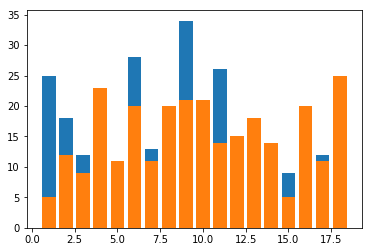

In [363]:
test_date = "43_dec-18.txt"
#markovify(test_date)
print("max_sent_len, min_sent_len, mean_sent_len, sd_sent_len,num_words,rare_words_count,num_sents")
print(sent_data(test_date)[1])
print(sent_data("_"+test_date)[1])
plot_sents(test_date)
plot_sents("_"+test_date)

<h1> GRAPH SECTION </h1>

In [303]:
def graph_data(fn,verbose=True):
    g = graph_dict[fn[:-4]]
    d = dict(nx.degree(g))
    max_degree = max(d.values())
    hubs = sorted(zip(d.values(),d.keys()), reverse=True)[:3]
    hubs_deg = hubs[0][0]+hubs[1][0]+hubs[2][0]
    loss=g.number_of_edges()+1-dtm_meta.at[fn,"num_words"]
    diameter = nx.diameter(g)
    center = nx.center(g)
    clustering = nx.average_clustering(g)
    #closeness = nx.closeness_centrality(g).values()
    dom_set = nx.dominating_set(g)
    try:
        max_ind = nx.maximal_independent_set(g)
    except:
        max_ind = {}
    if(verbose):
        print("hubs:",hubs)
        print("hubs_deg_sum:", hubs_deg)
        print("Loss:",loss)
        print("Diameter:",diameter)
        print("Center nodes:",center)
        print("Average clustering:", clustering)
        print("Dominating set:",dom_set)
        print("Dominating set length:",len(dom_set))
        print("Maximal independent set:",max_ind)
        print("Maximal independent set length:",len(max_ind))
    return([hubs, hubs_deg, loss, diameter,center,len(center),clustering,dom_set,len(dom_set),max_ind,len(max_ind)])

<h3> Makes graphs for all files in directory </h3>

In [330]:
path='../corpora/peregrine/'
filenames = os.listdir(path)
graph_dict = {}
for f in filenames:
    if(f[-3:] == "txt" and f[0]!="-"):
        filetext = open(path+f, "r").read()
        graph_dict[f[:-4]]=makegraph(getsents(filetext))

<h3> Makes graphs for all files in directory </h3>

In [306]:
def make_graph_dtm(text_folder,normalize=False):

    # make an empty results list
    all_results = []
    
    columns=[]

    attrbs = ['hubs', 'hubs_deg_sum','loss','diameter',
             'center', 'center_len','clustering','dom_set','len_dom_set','indep_set', 'len_indep_set']
    columns.append('fn')
    for att in attrbs:
        columns.append(att)
    
    # for each filename
    filenames=sorted(os.listdir(text_folder))
    for fn in filenames:
        if(fn[-3:]=="txt"):
            text_result = {}
            text_result["fn"]=fn
            gd = graph_data(fn, False)
            
            text_result['hubs']=gd[0]
            text_result['hubs_deg_sum']=gd[1]
            text_result['loss']=gd[2]
            text_result['diameter']=gd[3]
            text_result['center']=gd[4]
            text_result['center_len'] = gd[5]
            text_result['clustering']=gd[6]
            text_result['dom_set']=gd[7]
            text_result['len_dom_set']=gd[8]
            text_result['indep_set']=gd[9]
            text_result['len_indep_set']=gd[10]
            all_results.append(text_result)
            
    
    # Make dataframe
    df = pd.DataFrame(all_results, columns=columns).set_index('fn').fillna(0)
    
    # return dataframe
    return df

In [331]:
gdtm = make_graph_dtm(text_folder,normalize=True)
gdtm_meta=df_meta.merge(gdtm,on='fn')
#gdtm_meta = gdtm_meta[dtm_meta.author !="gpt-2"]
gdtm_meta

,season,author,hubs,hubs_deg_sum,loss,diameter,center,center_len,clustering,dom_set,len_dom_set,indep_set,len_indep_set
fn,,,,,,,,,,,,,
00_oct-1.txt,fall,baker,"[(12, sky), (12, jay), (12, hawk)]",36,-358,14,"[sky, alder, river, hawk, water, watching, bli...",31,0.010929,"{seldom, swept, perch, rest, mask, as, breakin...",151,"[go, oak, hissed, watched, fovea, watching, ar...",154
01_oct-3.txt,fall,baker,"[(12, wader), (11, beach), (10, sea)]",33,-112,14,"[sun, sea, flashing, salting, wader, white, be...",26,0.000000,"{slashed, sable, preening, cooling, could, leg...",69,"[ringer, hundred, rose, wader, far, shimmering...",72
02_oct-5.txt,fall,baker,"[(12, wing), (10, long), (9, hawk)]",31,-264,13,[orchard],1,0.004715,"{rain, goldfinch, hawk, rain-smoked, separate,...",113,"[small, red-brown, a, wafting, wooded, spun, c...",119
03_oct-7.txt,fall,baker,"[(14, wing), (8, peregrine), (6, tail)]",28,-320,18,"[foot, two, hundred, passing, twice, as, a, gr...",21,0.016136,"{separate, swept, oddly, overhead, as, skylark...",122,"[fur, beneath, surface, hour, effect, field, f...",120
04_oct-8.txt,fall,baker,"[(15, wader), (12, like), (9, inland)]",36,-169,15,"[flew, like, wader, small, facing]",5,0.020095,"{alert, hawk, stayed, harmless, many, brown, t...",77,"[jostling, dangerous, formed, turning, stubble...",79
05_oct-9.txt,fall,baker,"[(8, sun), (8, like), (6, jay)]",22,-153,17,"[hid, shining, martin, flew, hawk]",5,0.000000,"{meat, hawk, stayed, dwindling, brown, pike, s...",77,"[north, sunlight, swamp, saw, insipid, stay, f...",78
06_oct-12.txt,fall,baker,"[(22, hawk), (16, crow), (12, like)]",50,-349,15,"[away, peregrine, come, inland, estuary, hawk,...",16,0.005779,"{beat, brown, tide, rest, gnarled, as, eleven,...",140,"[flinging, rising, wader, shark, swarm, quench...",142
07_oct-14.txt,fall,baker,"[(14, water), (8, peregrine), (8, godwit)]",30,-76,20,"[white, glinting, water, grey, plover, seldom,...",11,0.007088,"{seldom, sadness, zostera, dwindling, sneezing...",80,"[insistent, widening, shrill, rafter, revolve,...",79
08_oct-15.txt,fall,baker,"[(10, peregrine), (10, flew), (10, falcon)]",30,-210,18,"[peregrine, tiercel, falcon, quicker, plumage]",5,0.008955,"{hawk, many, brown, roost, a, gather, quickly,...",91,"[angle, rush, falcon, true, circle, jackdaw, t...",88


In [332]:
gdtm_meta.groupby('author').mean()

,hubs_deg_sum,loss,diameter,center_len,clustering,len_dom_set,len_indep_set
author,,,,,,,
baker,33.275862,-269.804598,17.701149,6.988506,0.011279,107.747126,108.620690
markov,31.678161,-344.609195,16.666667,7.310345,0.011902,105.080460,104.885057


In [368]:
checkfile="54_jan-25"
_g = graph_dict["_"+checkfile]
_gd = graph_data("_"+checkfile+".txt")

hubs: [(12, 'peregrine'), (10, 'white'), (10, 'hawk')]
hubs_deg_sum: 32
Loss: -517
Diameter: 13
Center nodes: ['hawk', 'as', 'a', 'sea', 'must', 'glided', 'suddenly', 'north', 'rushed']
Average clustering: 0.008694303663815859
Dominating set: {'glare', 'plunge', 'pursue', 'sea', 'many', 'perch', 'absorbed', 'brown', 'echo', 'ride', 'summer', 'reflective', 'pierced', 'as', 'puff', 'pasture', 'glared', 'frost', 'around', 'north', 'tree', 'impelling', 'life', 'song', 'pond', 'waning', 'small', 'peacefully', 'breast', 'warm', 'six', 'killed', 'downstream', 'straight', 'swooped', 'line', 'furiously', 'muscular', 'sombre', 'jerked', 'flight', 'hide', 'higher', 'fragment', 'throughout', 'west', 'gold', 'oclock', 'saw', 'unrelenting', 'without', 'seen', 'remains', 'fire', 'mile', 'though', 'could', 'lost', 'leaf', 'damp', 'tractor', 'flew', 'sunlight', 'clustered', 'past', 'left', 'road', 'ice', 'ploughing', 'swung', 'sweeping', 'boomed', 'east', 'dust', 'counter-shading', 'force', 'across', '

In [369]:
g = graph_dict[checkfile]
gd = graph_data(checkfile+".txt")

hubs: [(24, 'snow'), (22, 'like'), (9, 'blood')]
hubs_deg_sum: 55
Loss: -301
Diameter: 20
Center nodes: ['like', 'moorhen', 'ice', 'diving', 'saw', 'coming', 'six', 'hare', 'crouched', 'together', 'hawthorn', 'bar', 'grey', 'pheasant', 'plunged', 'foot', 'pair', 'gaunt', 'hole', 'blood']
Average clustering: 0.011057411559083798
Dominating set: {'slithered', 'goldfinch', 'foot-deep', 'copper', 'loud', 'marrow', 'separate', 'many', 'pike', 'pierced', 'as', 'hate', 'skylark', 'spray', 'tremulously', 'low', 'hovered', 'camel', 'tower', 'glowing', 'north', 'tree', 'impelling', 'fiercely', 'way', 'trudged', 'waning', 'small', 'danced', 'torch-lit', 'fieldfare', 'moving', 'dragged', 'herring', 'foot', 'six', 'killed', 'contorting', 'hurtling', 'outer', 'fish-blood', 'brittle', 'turning', 'sloping', 'thin', 'cattle', 'men', 'apple', 'beside', 'threaded', 'open', 'torn', 'tangle', 'something', 'bill', 'torpedoed', 'adjective', 'brain', 'bar', 'burning', 'though', 'walked', 'fifteen', 'love', 't

In [370]:
draw_graph3(_g)

In [371]:
draw_graph3(g)

In [127]:
def concordance(text_folder,filename,word,width=100,lines=1000):
    # Get the path
    text_path = os.path.join(text_folder, filename)
    print(text_path)

    # Open the file
    with open(text_path) as file:
        text_txt=file.read()

    # make nltk version of the text (useful for concordance)
    import nltk
    text_words = nltk.word_tokenize(text_txt)
    text_nltk = nltk.text.Text(text_words)

    # get concordance
    text_nltk.concordance(word,width=width,lines=lines)
    

In [128]:
concordance(text_folder,'_'+checkfile+".txt","like")
concordance(text_folder,checkfile+".txt","like")

../corpora/peregrine/_52_jan-9.txt
Displaying 1 of 1 matches:
hundred woodpigeons clattered up from the mud , like damp squibs . None moved when I walked towards 
../corpora/peregrine/52_jan-9.txt
Displaying 1 of 1 matches:
awks . Their eyes see maps of black and white , like a crackle of silent film . The moving black is 
